### Here we use Keras with Tensorflow backend to try differnet CNN with different hyperparameters and regularization method

In [1]:
# Import all modules
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils
from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")
import tensorflow as tf
import multiprocessing as mp
from keras.datasets import cifar10

Using TensorFlow backend.


In [2]:
batch_size = 32 
num_classes = 10 
epochs = 100

### Load Data

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() 
# x_train - training data(images), y_train - labels(digits)
class_names={0:'airplane',
            1:'automobile',
            2:'bird',
            3:'cat',
            4:'deer',
            5:'dog',
            6:'frog',
            7:'horse',
            8:'ship',
            9:'truck'}
print(y_train[:10])
print(x_train[1].shape)

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]
(3, 32, 32)


### Random show 10 pictures from each class

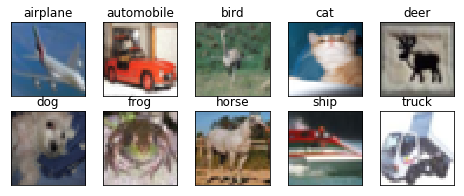

In [4]:
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[img_num,::],(1,2,0))
    ax.set_title(class_names[i])
    
    plt.imshow(im)
plt.show()

In [5]:
# Convert and pre-processing

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255

### After per-processing our label data change to a one-hot vector, 1 means the true class.
### Traing data is (3,32,32) array represnt 32 x 32 resolution in RGB color.

In [6]:
print(y_train[:10])
print(x_train[1].shape)

[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]]
(3, 32, 32)


### Model 1

In [19]:
def base_model(lr=0.1):

    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
    model.add(BatchNormalization())
    #model.add(Activation('relu'))
    #model.add(Activation('tanh'))
    model.add(PReLU())
    
    
    model.add(Conv2D(32,(3, 3)))
    model.add(BatchNormalization())
    #model.add(Activation('relu'))
    #model.add(Activation('tanh'))
    model.add(PReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
              
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    #model.add(Activation('relu'))
    model.add(PReLU())
    
              
              
    model.add(Conv2D(64, (3,3)))
    model.add(BatchNormalization())
    #model.add(Activation('relu'))
    #model.add(Activation('tanh'))
    model.add(PReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
              
              
    model.add(Flatten())
    model.add(Dense(512))
    #model.add(Activation('relu'))
    #model.add(Activation('tanh'))
    model.add(PReLU())
    
    
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    #sgd = SGD(lr = lr, decay=1e-6, momentum=0.9, nesterov=True)
    #sgd = SGD(lr = lr, decay=1e-6, momentum=0, nesterov=False)
    ada = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=ada, metrics=['accuracy'])
    return model
cnn_n = base_model(lr=0.0005)
cnn_n.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
p_re_lu_12 (PReLU)           (None, 32, 32, 32)        32768     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 30, 30)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 30, 30)        120       
_________________________________________________________________
p_re_lu_13 (PReLU)           (None, 32, 30, 30)        28800     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 15, 15)        0         
__________

In [21]:
# Fit model

cnn = cnn_n.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test),shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 34s 682us/step - loss: 1.8299 - acc: 0.3328 - val_loss: 1.3597 - val_acc: 0.5029
Epoch 2/100
50000/50000 [==============================] - 33s 658us/step - loss: 1.3184 - acc: 0.5278 - val_loss: 1.1008 - val_acc: 0.6069
Epoch 3/100
50000/50000 [==============================] - 34s 678us/step - loss: 1.0961 - acc: 0.6145 - val_loss: 0.9325 - val_acc: 0.6709
Epoch 4/100
50000/50000 [==============================] - 33s 668us/step - loss: 0.9520 - acc: 0.6676 - val_loss: 0.8320 - val_acc: 0.7079
Epoch 5/100
50000/50000 [==============================] - 34s 671us/step - loss: 0.8547 - acc: 0.7004 - val_loss: 0.7855 - val_acc: 0.7349
Epoch 6/100
50000/50000 [==============================] - 33s 669us/step - loss: 0.7669 - acc: 0.7316 - val_loss: 0.7355 - val_acc: 0.7425
Epoch 7/100
50000/50000 [==============================] - 34s 673us/step - loss: 0.7052 - acc: 0.7560 - val_l

Epoch 59/100
50000/50000 [==============================] - 34s 670us/step - loss: 0.1646 - acc: 0.9425 - val_loss: 0.7293 - val_acc: 0.8109
Epoch 60/100
50000/50000 [==============================] - 34s 672us/step - loss: 0.1616 - acc: 0.9424 - val_loss: 0.6993 - val_acc: 0.8166
Epoch 61/100
50000/50000 [==============================] - 34s 673us/step - loss: 0.1616 - acc: 0.9444 - val_loss: 0.7200 - val_acc: 0.8122
Epoch 62/100
50000/50000 [==============================] - 34s 677us/step - loss: 0.1578 - acc: 0.9461 - val_loss: 0.7314 - val_acc: 0.8194
Epoch 63/100
50000/50000 [==============================] - 34s 679us/step - loss: 0.1565 - acc: 0.9455 - val_loss: 0.7145 - val_acc: 0.8105
Epoch 64/100
50000/50000 [==============================] - 33s 669us/step - loss: 0.1501 - acc: 0.9476 - val_loss: 0.7618 - val_acc: 0.8135
Epoch 65/100
50000/50000 [==============================] - 34s 678us/step - loss: 0.1535 - acc: 0.9464 - val_loss: 0.7462 - val_acc: 0.8068
Epoch 66/100


In [8]:
# Vizualizing model structure

sequential_model_to_ascii_printout(cnn_n)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####      3   32   32
              Conv2D    \|/  -------------------       896     0.1%
                       #####     32   32   32
               PReLU   ????? -------------------     32768     2.4%
                       #####     32   32   32
              Conv2D    \|/  -------------------      9248     0.7%
                       #####     32   30   30
               PReLU   ????? -------------------     28800     2.2%
                       #####     32   30   30
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     32   15   15
             Dropout    | || -------------------         0     0.0%
                       #####     32   15   15
              Conv2D    \|/  -------------------     18496     1.4%
                       #####     64   15   15
               PReLU   ????? -------------------     14400     1.1%
              

0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000
[[841  11  19  15  18   3   5  13  43  32]
 [  7 908   0   3   2   2   7   2  10  59]
 [ 64   3 665  56  75  46  46  28  10   7]
 [ 20   9  39 689  48 108  39  32   3  13]
 [  9   2  37  48 799  18  31  51   4   1]
 [  5   3  22 163  34 698  13  53   2   7]
 [  4   2  20  49  24   6 885   6   2   2]
 [  6   0   7  26  36  24   1 897   0   3]
 [ 31  19   3  11   3   4   2   2 899  26]
 [ 20  45   3  11   2   1   4  10  16 888]]


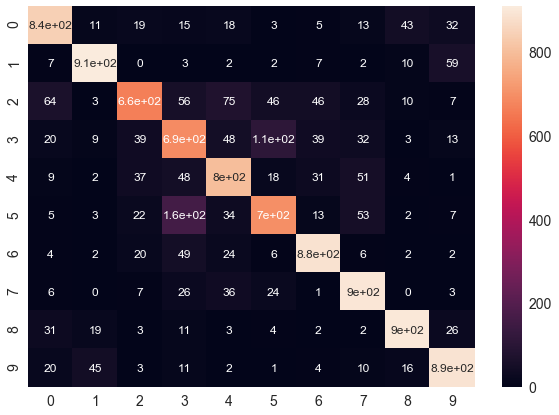

In [22]:
# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix
Y_pred = cnn_n.predict(x_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)

for ix in range(10):
    print(ix, confusion_matrix(np.argmax(y_test,axis=1),y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)

# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd


df_cm = pd.DataFrame(cm, range(10),
                  range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()

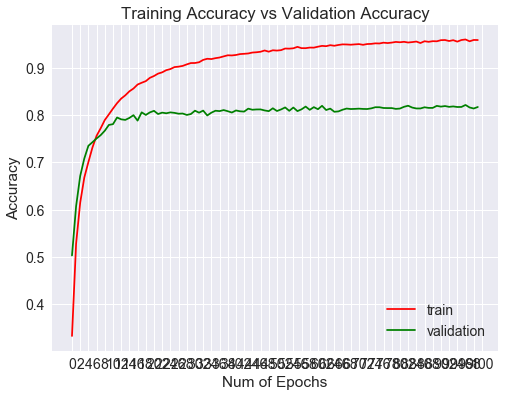

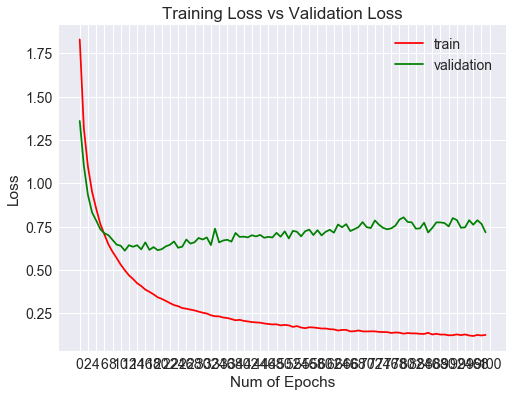

In [23]:
# Plots for training and testing process: loss and accuracy

plt.figure(0)
plt.plot(cnn.history['acc'],'r')
plt.plot(cnn.history['val_acc'],'g')
plt.xticks(np.arange(0, 101, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])


plt.figure(1)
plt.plot(cnn.history['loss'],'r')
plt.plot(cnn.history['val_loss'],'g')
plt.xticks(np.arange(0, 101, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])


plt.show()